In [1]:
import cv2
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.fftpack import dct
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

# Load dataset

In [2]:
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.3)   

train_dataset  = train_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)
validation_dataset  = train_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'validation',
                                                   shuffle=True,
                                                   batch_size = 64)


test_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)   

test_dataset  = test_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/test',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=False,
                                                   batch_size = 64)

Found 7000 images belonging to 20 classes.
Found 3000 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.


# DenseNet121

In [3]:
input_layer = K.Input(shape=(160,160,3))
effnet_model = K.applications.DenseNet121(include_top = False, weights = "imagenet", input_tensor = input_layer)
for layer in effnet_model.layers:
    layer.trainable = False
for i, layer in enumerate(effnet_model.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 zero_padding2d - False
2 conv1/conv - False
3 conv1/bn - False
4 conv1/relu - False
5 zero_padding2d_1 - False
6 pool1 - False
7 conv2_block1_0_bn - False
8 conv2_block1_0_relu - False
9 conv2_block1_1_conv - False
10 conv2_block1_1_bn - False
11 conv2_block1_1_relu - False
12 conv2_block1_2_conv - False
13 conv2_block1_concat - False
14 conv2_block2_0_bn - False
15 conv2_block2_0_relu - False
16 conv2_block2_1_conv - False
17 conv2_block2_1_bn - False
18 conv2_block2_1_relu - False
19 conv2_block2_2_conv - False
20 conv2_block2_concat - False
21 conv2_block3_0_bn - False
22 conv2_block3_0_relu - False
23 conv2_block3_1_conv - False
24 conv2_block3_1_bn - False
25 conv2_block3_1_relu - False
26 conv2_block3_2_conv - False
27 conv2_block3_concat - False
28 conv2_block4_0_bn - False
29 conv2_block4_0_relu - False
30 conv2_block4_1_conv - False
31 conv2_block4_1_bn - False
32 conv2_block4_1_relu - False
33 conv2_block4_2_conv - False
34 conv2_block4_concat - False
35 c

# CBAM 

In [4]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape
    ## Shared layers
    l1 = K.layers.Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = K.layers.Dense(channel, use_bias=False)
    ## Global Average Pooling
    x1 = K.layers.GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)
    ## Global Max Pooling
    x2 = K.layers.GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)
    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = K.layers.Activation("sigmoid")(feats)
    feats = K.layers.Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)
    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)
    ## Concatenat both the features
    feats = K.layers.Concatenate()([x1, x2])
    ## Conv layer
    feats = K.layers.Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = K.layers.Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

In [3]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    recall = true_positives / (possible_positives + Kback.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kback.epsilon())
    return f1_val

METRICS = [
      "accuracy",
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
      f1_score
]

In [6]:
inputs = K.layers.Input(shape=(160,160,3), name="image") 

resnet50 = effnet_model(inputs)
cbam_lay = cbam(resnet50)
flat = K.layers.GlobalAveragePooling2D()(cbam_lay)
output = K.layers.Dense(20, activation='softmax')(flat)

model = K.Model(inputs=inputs, outputs=output)
optimizer = K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet121 (Functional)       (None, 5, 5, 1024)   7037504     ['image[0][0]']                  
                                                                                                  
 global_average_pooling2d (Glob  (None, 1024)        0           ['densenet121[0][0]']            
 alAveragePooling2D)                                                                              
                                                                                              

C:\Python\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training

In [7]:
model_checkpoint_callback = K.callbacks.ModelCheckpoint(
    filepath='densenet121_cbam.hdf5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
    )

history = model.fit(train_dataset,
                    epochs = 50,
                    validation_data = validation_dataset,
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/50
110/110 [==============================] - ETA: 0s - loss: 1.3393 - accuracy: 0.6474 - precision: 0.8890 - recall: 0.2839 - auc: 0.9628 - f1_score: 0.3777
Epoch 1: val_accuracy improved from -inf to 0.77300, saving model to inceptionv3.hdf5
110/110 [==============================] - 616s 6s/step - loss: 1.3393 - accuracy: 0.6474 - precision: 0.8890 - recall: 0.2839 - auc: 0.9628 - f1_score: 0.3777 - val_loss: 0.6765 - val_accuracy: 0.7730 - val_precision: 0.8470 - val_recall: 0.6293 - val_auc: 0.9889 - val_f1_score: 0.7207
Epoch 2/50
110/110 [==============================] - ETA: 0s - loss: 0.4447 - accuracy: 0.8814 - precision: 0.9275 - recall: 0.7746 - auc: 0.9968 - f1_score: 0.8417
Epoch 2: val_accuracy improved from 0.77300 to 0.82900, saving model to inceptionv3.hdf5
110/110 [==============================] - 609s 6s/step - loss: 0.4447 - accuracy: 0.8814 - precision: 0.9275 - recall: 0.7746 - auc: 0.9968 - f1_score: 0.8417 - val_loss: 0.4703 - val_accuracy: 0.8290 - v

Epoch 17/50
110/110 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9969 - precision: 0.9974 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9971
Epoch 17: val_accuracy improved from 0.89833 to 0.90400, saving model to inceptionv3.hdf5
110/110 [==============================] - 603s 5s/step - loss: 0.0183 - accuracy: 0.9969 - precision: 0.9974 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9971 - val_loss: 0.3255 - val_accuracy: 0.9040 - val_precision: 0.9083 - val_recall: 0.9010 - val_auc: 0.9907 - val_f1_score: 0.9046
Epoch 18/50
110/110 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9996
Epoch 18: val_accuracy improved from 0.90400 to 0.90500, saving model to inceptionv3.hdf5
110/110 [==============================] - 601s 5s/step - loss: 0.0088 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9996 - val_loss: 0.3287 - val_accuracy: 0.9

Epoch 33/50
110/110 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996
Epoch 33: val_accuracy did not improve from 0.91100
110/110 [==============================] - 600s 5s/step - loss: 0.0018 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996 - val_loss: 0.3650 - val_accuracy: 0.9097 - val_precision: 0.9130 - val_recall: 0.9060 - val_auc: 0.9868 - val_f1_score: 0.9096
Epoch 34/50
110/110 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996
Epoch 34: val_accuracy did not improve from 0.91100
110/110 [==============================] - 600s 5s/step - loss: 0.0019 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996 - val_loss: 0.3729 - val_accuracy: 0.9077 - val_precision: 0.9110 - val_recall: 0.9047 - val_auc: 0.9864 - val_f1_

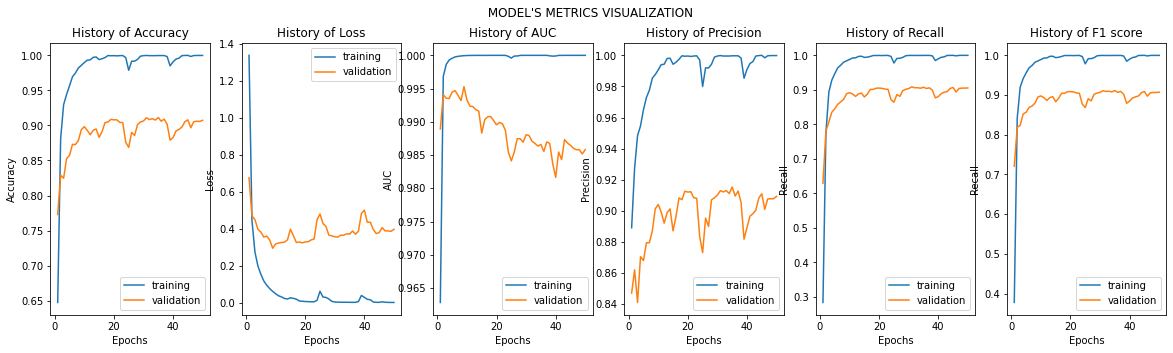

In [8]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,recall,val_recall,f1_score,val_f1_score):
    
    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_recall)
    ax5.set_title('History of Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])

    ax6.plot(range(1, len(f1_score) + 1), f1_score)
    ax6.plot(range(1, len(val_f1_score) + 1), val_f1_score)
    ax6.set_title('History of F1 score')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('Recall')
    ax6.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['recall'],history.history['val_recall'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [23]:
model.layers[-2].output

<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'global_average_pooling2d_1')>

# Testing

In [4]:
model = K.models.load_model("densenet121_cbam.hdf5", custom_objects={"f1_score": f1_score})
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
print("Testing Loss:")
print(loss)
print("Testing Accuracy:")
print(accuracy)
print("Testing Precision:")
print(precision)
print("Testing Recall:")
print(recall)
print("Testing F1-Score:")
print(f1_score)
print("Testing AUC:")
print(auc)

32/32 [==============================] - 105s 3s/step - loss: 0.4833 - accuracy: 0.9010 - precision: 0.9044 - recall: 0.8990 - auc: 0.9801 - f1_score: 0.9006
Testing Loss:
0.48327958583831787
Testing Accuracy:
0.9010000228881836
Testing Precision:
0.9044265747070312
Testing Recall:
0.8989999890327454
Testing F1-Score:
0.9006023406982422
Testing AUC:
0.9800604581832886


C:\Users\aroy8\AppData\Local\Temp/ipykernel_7044/4018378087.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 2000)
Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2000 batches). You may need to use the repeat() function when building your dataset.


Confusion Matrix


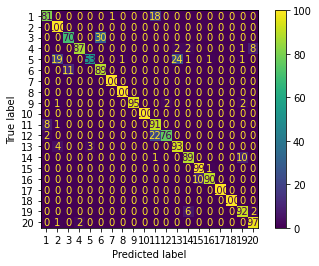

Classification Report
              precision    recall  f1-score   support

           1       0.89      0.81      0.85       100
           2       0.79      1.00      0.88       100
           3       0.86      0.70      0.77       100
           4       0.98      0.87      0.92       100
           5       0.95      0.53      0.68       100
           6       0.75      0.89      0.81       100
           7       0.99      1.00      1.00       100
           8       0.99      1.00      1.00       100
           9       1.00      0.95      0.97       100
          10       1.00      1.00      1.00       100
          11       0.69      0.91      0.78       100
          12       0.97      0.76      0.85       100
          13       0.78      0.93      0.85       100
          14       0.91      0.89      0.90       100
          15       0.91      0.99      0.95       100
          16       0.98      0.90      0.94       100
          17       1.00      1.00      1.00       100
     

In [5]:
Y_pred = model.predict_generator(test_dataset, 2000)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))